# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Custom Modules.
from Game import Game
from Player import Player

# Custom Functions.
from RecursePlayer import recursePlayer,dealHouse,getReward,getValue
from Q_Learning import initQ,learnPolicy,evaluatePolicy,getBestAction
from Utils import dfBestMove

# Rewards Distribution

Given random gameplay, what are the expected reward for each state-action pair?

### Here, I can specifically state which combinations I want played. However, right now, I assume plentiful cards. Will not serve as optimal policy evaluation, but rather expected rewards given a state - action pair.

So, every combination is possible (hardcoded in), and the next card drawn is uniformly, with replacement. 

Might introduce some bias. Imagine player shows [2,2], the odds of them drawing another 2 should be lower, but this method does not say so.

I use discounted rewards. For example:
- Player shows 5, they hit to get 9, hit to get 12, hit to get 20, stay, and ends up winning the hand.
- I'm most interested in the move taken when player has 20.
- How I handle this is by using the gamma hyperparameter and discounting earlier moves more

Initialize the simulation

In [5]:
blackjack = Game(Player)
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

moves = ['stay','hit','double','surrender','split']

pairsSplit = {(c,c):i for i,c in enumerate(allCards)}
pairsSplit = {}
count = 0
for c in allCards :
    pairsSplit[(c,c)] = count
    if c not in [10,'J','Q'] :
        count += 1
    

# initialize arrays for totals + rewards
# dimensions are (m,a,p,h)
# - m : # of possible moves
# - a : useable ace or not
# - p : # of possible totals (includes 0,1,2,3 for simplicity), PLUS # of pairs
# - h : # of possible house face-up card (includes 0,1,2,3 for simplicity)

totals = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))
rewards = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))

gamma = .7

nTrials = 2000

Run the trail

In [6]:
for n in range(nTrials) :
    print('{} of {}'.format(n,nTrials),end='\r')
    for i in range(len(allCards)) :
        for j in range(i,len(allCards)) :
            cards = [allCards[i],allCards[j]]
            for h in range(len(allCards)) :
                houseCards,val,houseShow = dealHouse(allCards[h],cardMap,cardValues)
                seriesOut = recursePlayer(cards,allCards[h],cardMap,cardValues)

                for r in seriesOut :
                    if len(r)==0 :
                        totals[0,0,21,houseShow] += 1
                        rewards[0,0,21,houseShow] += 1.5
                        continue
                    reward = getReward(r,val)
                    
                    # I can discount earlier moves (hence reversing the order of moves)
                    # to more accurately reflect the benefit of hitting on smaller player cards shown.
                    for g,(playerShow,move,useableAce,pairSplit,nextVal) in enumerate(r[::-1]) :
                        indPlayer = playerShow
                        if pairSplit :
                            indPlayer = 22 + pairsSplit[tuple(pairSplit)]
                        totals[moves.index(move),int(useableAce),indPlayer,houseShow] += 1   
                        rewards[moves.index(move),int(useableAce),indPlayer,houseShow] += reward*gamma**g
            
            
normalized = np.zeros(totals.shape)
for m in range(len(moves)) :
    for i in [0,1] :
        # prevent division by zero, clip totals (shouldn't happen if # iterations is high enough)
        normalized[m][i] = rewards[m][i] / np.clip(totals[m][i],a_min=1,a_max=None)
            
            
        

In [2]:
#np.save('normalized.npy',normalized)
normalized = np.load('normalized.npy')

In [25]:
noAce,useableAce,canSplit = dfBestMove(normalized,moves,pairsSplit,colorBox=True)

In [8]:
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
8,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [26]:
useableAce

,2,3,4,5,6,7,8,9,10,11
13,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,St,Do,Do,Do,Do,St,St,St,St,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St
21,St,St,St,St,St,St,St,St,St,St


In [10]:
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(4, 4)",Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
"(6, 6)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Do,Do,Do,Sp,Sp,Sp,Sp,Sp


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
- Epsilon-Greedy Algorithm
- Thompson Sampling methods.

# Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [13]:
Q = [
    {
        'name':'e-Greedy Decay 1',
        'epsilon_decay':.000001,
        'min_epsilon':.1,
        'evaluation':[]
    }
]

nEpisodes = int(5e6)
nPlayers = 1
gamma = .8
lr = .01
nDecks = 6
ratioPenetrate = 4/6
wagers = [1]*nPlayers

nRoundsEvaluate = 500

moves = ['stay','hit','split','double','surrender']

earlyStop = True
e = 10 # early stopping criterion
every = 100 # interval to evaluate policy

In [127]:
for q in Q :
    q['Q'] = initQ(moves)
    blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
    
    r = 0
    counter = 0
    minPerformance = -10
    while r < nEpisodes :
        
        blackjack.initRound(wagers)
        houseBlackjack = blackjack.dealInit()
        if blackjack.houseBlackjack :
            continue
        eps = max(q['min_epsilon'],np.exp(-q['epsilon_decay']*n)) #exponential decay factor.
        learnPolicy(blackjack,q['Q'],nPlayers,eps,gamma,lr)
        
        if not r%every :
            blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
            p = np.mean(evaluatePolicy(blackjack,q['Q'],wagers,nRoundsEvaluate)[-1])
            q['evaluation'].append(p)
            
            print('Method {} : {} of {}. Score : {}'.format(q['name'],r+1,nEpisodes,p))
            
            if p < minPerformance : 
                counter += 1
            else :
                counter = 0
            minPerformance = max(minPerformance,p)
        
        if counter == e :
            
            print('Early Stopping at Round {}.'.format(r))
            break
        
        r += 1
    print('\n')

Method e-Greedy Decay 1 : 1 of 5000000. Score : -0.497
Method e-Greedy Decay 1 : 101 of 5000000. Score : -0.446
Method e-Greedy Decay 1 : 201 of 5000000. Score : -0.429
Method e-Greedy Decay 1 : 301 of 5000000. Score : -0.259
Method e-Greedy Decay 1 : 401 of 5000000. Score : -0.398
Method e-Greedy Decay 1 : 501 of 5000000. Score : -0.378
Method e-Greedy Decay 1 : 601 of 5000000. Score : -0.311
Method e-Greedy Decay 1 : 701 of 5000000. Score : -0.158
Method e-Greedy Decay 1 : 801 of 5000000. Score : -0.21
Method e-Greedy Decay 1 : 901 of 5000000. Score : -0.213
Method e-Greedy Decay 1 : 1001 of 5000000. Score : -0.268
Method e-Greedy Decay 1 : 1101 of 5000000. Score : -0.187
Method e-Greedy Decay 1 : 1201 of 5000000. Score : -0.302
Method e-Greedy Decay 1 : 1301 of 5000000. Score : -0.19
Method e-Greedy Decay 1 : 1401 of 5000000. Score : -0.197
Method e-Greedy Decay 1 : 1501 of 5000000. Score : -0.224
Method e-Greedy Decay 1 : 1601 of 5000000. Score : -0.152
Method e-Greedy Decay 1 : 17

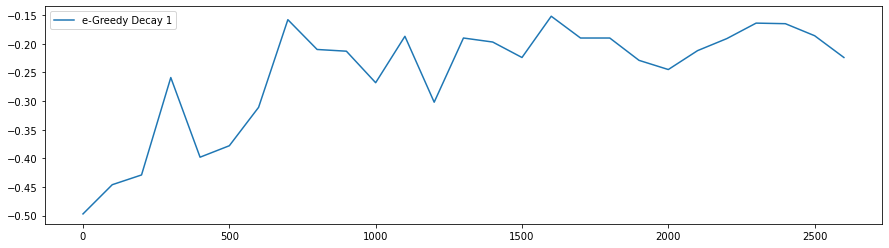

In [129]:
plt.figure(figsize=(15,4))
for q in Q :
    plt.plot(np.arange(0,len(q['evaluation']))*every,q['evaluation'],label=q['name'])

plt.legend()
plt.show()

In [20]:
#np.save('Q',Q[0]['Q'])
Qlearned = np.load('Q.npy',allow_pickle=True).item()

Evaluate new policy, as well as a random one, and a simple one.

Generated Random Rewards
Generated Learned Rewards
Generated Meh Rewards


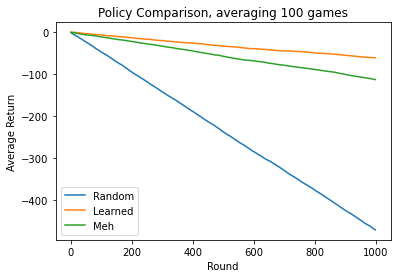

In [23]:
nRoundsEvaluate = 1000

randQ = initQ(['stay','hit','split','double','insurance','surrender'])
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
randomRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,randQ,wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)
print('Generated Random Rewards')
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
try : # is Qlearned has been defined, as read in from file.
    learnedRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)
except :
    learnedRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,Q[0]['Q'],wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)
print('Generated Learned Rewards')

somewhatSmartQ = {}
moves = ['stay','hit','double']
for p in range(4,22) :
    for h in range(2,12) :
        if (21 > p > 11)   :
            for a in [True,False] :
                if p < 17 :
                    somewhatSmartQ[(p,h,a)] = {'stay':0,'hit':1,'double':0}
                else :
                    somewhatSmartQ[(p,h,a)] = {'stay':1,'hit':0,'double':0}
        else :
            if p < 17 :
                somewhatSmartQ[(p,h,False)] = {'stay':0,'hit':1,'double':0}
            else :
                somewhatSmartQ[(p,h,False)] = {'stay':1,'hit':0,'double':0}

blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
mehRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,somewhatSmartQ,wagers,nRoundsEvaluate)[0]) for _ in range(100)],axis=0)
print('Generated Meh Rewards')

plt.title('Policy Comparison, averaging 100 games')
plt.plot(randomRewards,label='Random')
plt.plot(learnedRewards,label='Learned')
plt.plot(mehRewards,label='Meh')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

Play a hand according to learned policy.

In [25]:
blackjack = Game(Player,verbose=False)

blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)


while not player.isDone() :

    playerShow,useableAce = player.getValue()

    policy = player.getValidMoves(houseShow)
    policy = [p for p in policy if p!='insurance']
    try :
        move = getBestAction(Qlearned[(playerShow,houseShow,useableAce)],policy,-1)
    except :
        move = getBestAction(Q[0]['Q'][(playerShow,houseShow,useableAce)],policy,-1)
    print(player.cards,move)
    
    blackjack.stepPlayer(player,move)
    
blackjack.stepHouse()

print(blackjack.house.cards)
blackjack.getResults()

[[4, 3]] hit
[[4, 3, 3]] hit
[[4, 3, 3, 5]] stay
[['K', 10]]


([['loss']], [-1])